In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score,classification_report

import lazypredict
from lazypredict.supervised import LazyClassifier

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

## Import des données

In [64]:
df = pd.read_csv("dataset_final.csv")
df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute
0,1,1,3,1,2008.00,5,2,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,2,0,2,1,9,1,2022,16,15
1,1,1,1,1,1948.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,7,0,2,2,1,1,2022,16,15
2,1,1,4,1,1988.00,9,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,7,0,2,8,15,1,2022,8,34
3,1,1,1,1,1970.00,4,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,10,0,2,1,1,1,2022,8,34
4,1,1,1,1,2002.00,0,1,0,-1,-1,-1,-1,3,0.00,-1,2,0,1,1,-1.00,1,5,1,50,202200000003.00,20,10,2022,1,22,22360,2,6,1,2,48.49,-2.76,2,7,0,2,1,2,1,2022,17,15


## Préprocessing

### Le nombre d'accident selon la place occupé dans le transports

La variable "-1" correspond à "non concerné" et sont constitués de 25 lignes. Elles sont donc supprimés.

In [65]:
df = df.loc[df['place'] >= 1]

In [66]:
# trajet : transformer les non concerné en non renseigné
df['trajet'] = df['trajet'].mask(df['trajet'] < 0, 0)

# locp : regroupement de catégorie entre elles
df['locp'] = df['locp'].replace([2, 4], # 1 et 2 => 1 pour piéton sur chaussé
                                [1, 2]) # 3 et 4 => 2 pour piéton sur passage piéton

df['locp'] = df['locp'].replace([5,6,7,8,9], 3) # 5 à 9 => 3 pour piéton sur divers

# regrouper le nb de voies supérieur à 9 en une variable : plus de 9                                  
df['nbv'] = df['nbv'].replace([9,10,11,12,13], 9) # 9 à 13 => 9 pour plus de 9 voies

In [67]:
df.nbv.value_counts()

nbv
 2    294178
 4     63137
 1     46675
 3     41387
 6     14756
 0     11359
 5      9203
-1      4782
 8      4780
 9      2302
 7      1598
Name: count, dtype: int64

In [68]:
# création d'une tranche d'age
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] # 1: 0 à 10, 2: 21-30, '3: 31-40, 4: 41-50, 5: 51-60, 6: 61-70, 7: 70 et plus


df['age'] = df['an'] - df['an_nais']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['age_group'] = df['age_group'].replace([7, 8, 9, 10, 11, 12, 13], 7)

df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute,age,age_group
0,1,1,3,1,2008.00,5,2,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,2,0,2,1,9,1,2022,16,15,14.00,2
1,1,1,1,1,1948.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,7,0,2,2,1,1,2022,16,15,74.00,7
2,1,1,4,1,1988.00,9,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,7,0,2,8,15,1,2022,8,34,34.00,4
3,1,1,1,1,1970.00,4,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,10,0,2,1,1,1,2022,8,34,52.00,6
4,1,1,1,1,2002.00,0,1,0,-1,-1,-1,-1,3,0.00,-1,2,0,1,1,-1.00,1,5,1,50,202200000003.00,20,10,2022,1,22,22360,2,6,1,2,48.49,-2.76,2,7,0,2,1,2,1,2022,17,15,20.00,3


In [69]:
# mode de déplacement

# marche = 0
df['catv'] = df['catv'].mask(df['catv'] < 0, 0)

# edpm : trotinette électriques, monoroues, gyropodes, etc = 1
df['catv'] = df['catv'].replace([50, 60, 41, 42, 43], 100)

# vélo = 2
df['catv'] = df['catv'].replace([1, 80], 200)

# 2RM = 3
df['catv'] = df['catv'].replace([2, 4, 5, 6, 30, 31, 32, 33, 34, 35, 36], 300)

# VT (transports en commun) = 4
df['catv'] = df['catv'].replace([18, 19, 37, 38, 39, 40], 400)

# VU (véhicule utilitaire) et PL = 5
df['catv'] = df['catv'].replace([10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 99], 500)

# VL (voiture)  = 6
df['catv'] = df['catv'].replace([3, 7, 8, 9], 600)

df['catv'] = df['catv'].replace([100, 200, 300, 400, 500, 600], [1, 2, 3, 4, 5, 6])

df.catv.value_counts()

catv
6    315591
3     87268
5     49776
2     24105
1      9163
4      7184
0      1070
Name: count, dtype: int64

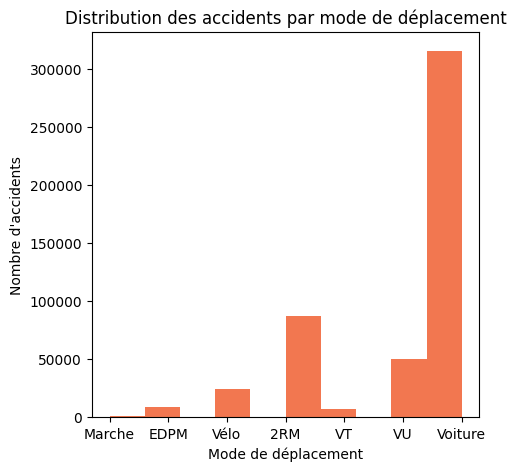

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize= (5, 5))
plt.hist(df['catv'],  color = ['#f27750'], label = ['catv'])

plt.xlabel("Mode de déplacement")
plt.ylabel("Nombre d'accidents")
plt.xticks([0,1, 2, 3,4,5,6], ['Marche', 'EDPM', "Vélo", "2RM", "VT", "VU", "Voiture"])
plt.title('Distribution des accidents par mode de déplacement')
plt.show();

In [71]:
# présence ou absence de système de sécurité
df['secu1'] = df['secu1'].replace([1, 2, 3, 4, 5, 6, 7, 9], 1)  # présence

df['secu1'] = df['secu1'].replace([0, 8], 2)                    # absence
df['secu1'] = df['secu1'].mask(df['catv'] < 0, 2)

df.secu1.value_counts()

secu1
 1    388294
 2    100297
-1      5566
Name: count, dtype: int64

In [72]:
# création d'une tranche horaire

bins = [1, 5, 7, 10, 13, 16, 19, 22]
labels = [100, 200, 300, 400, 500, 600, 700]

df['h_group'] = pd.cut(df['heure'], bins=bins, labels=labels, right=False)
df['h_group'] = df['h_group'].replace([100, 200, 300, 400, 500, 600, 700], [1, 2, 3, 4, 5, 6, 7])

df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute,age,age_group,h_group
0,1,1,3,1,2008.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2022,16,15,14.00,2,6
1,1,1,1,1,1948.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,2022,16,15,74.00,7,6
2,1,1,4,1,1988.00,9,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,2022,8,34,34.00,4,3
3,1,1,1,1,1970.00,4,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,2022,8,34,52.00,6,3
4,1,1,1,1,2002.00,0,1,0,-1,-1,-1,-1,3,0.00,-1,2,0,1,1,-1.00,1,5,1,50,202200000003.00,20,10,2022,1,22,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,2022,17,15,20.00,3,6


In [73]:
print(df.grav.value_counts())

print("-1 : non concerné, 1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger")


grav
 1    207351
 4    197494
 3     75986
 2     13047
-1       279
Name: count, dtype: int64
-1 : non concerné, 1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger


Comme on a pu le voir précédemment, le jeu de données est déséquilibré sur la variable cible. Par exemple, la proportion d'accident mortel est plus faible que celle d'indemne.

### Combinaison de indemne et non concerné

In [74]:
# combiner les variables indemne et non concerné car si la personne 
# n'est pas concerné par la gravité c'est qu'elle est indemne

df.grav = df.grav.astype(str)
df.grav = [value.replace("-1", "1") for value in df["grav"]]
df.grav = [value.replace("3", "2") for value in df["grav"]]
df.grav = [value.replace("4", "2") for value in df["grav"]]
df.grav = df.grav.astype(int)

df.grav = df.grav.astype(str)
df.grav = [value.replace("1", "0") for value in df["grav"]]
df.grav = [value.replace("2", "1") for value in df["grav"]]
df.grav = df.grav.astype(int)

print(df.grav.value_counts())

print("")
print("Variables d'origines :", "1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger")
print("Nouvelles variables  :", "1 – Accident sans gravité, 2 – Accident avec gravité")

# Pour la suite, je souhaite conserver pour la variable gravité les catégories indemne, tué, blessé hospitalisé 
# et blessé léger qui me paraissent intéressantes pour traiter le problème.

grav
1    286527
0    207630
Name: count, dtype: int64

Variables d'origines : 1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger
Nouvelles variables  : 1 – Accident sans gravité, 2 – Accident avec gravité


In [75]:
# Travail sur les dates

# mois
df.mois.value_counts()

np.corrcoef(df['mois'], df['grav'])

# jour
df.jour.value_counts()

np.corrcoef(df['jour'], df['grav'])

array([[1.        , 0.00129801],
       [0.00129801, 1.        ]])

En ce qui concerne les mois et le jour de l'aacident, la corrélation est très proche de zéro, indiquant une relation linéaire très faible entre ces deux variables. De plus il n'y a pas de différences significatives sur la quantité d'accidents en fonction des mois ou des jours. 



In [76]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute,age,age_group,h_group
0,1,1,1,1,2008.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2022,16,15,14.00,2,6
1,1,1,0,1,1948.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,2022,16,15,74.00,7,6
2,1,1,1,1,1988.00,9,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,2022,8,34,34.00,4,3
3,1,1,0,1,1970.00,4,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,2022,8,34,52.00,6,3
4,1,1,0,1,2002.00,0,1,0,-1,-1,-1,-1,3,0.00,-1,2,0,1,1,-1.00,1,5,1,50,202200000003.00,20,10,2022,1,22,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,2022,17,15,20.00,3,6


In [77]:
df['date_obj'] = pd.to_datetime(df['an'].astype(str) + '-' + df['mois'].astype(str) + '-' + df['jour'].astype(str))

df['weekday'] = df['date_obj'].apply(lambda x: x.weekday())

df.head()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute,age,age_group,h_group,date_obj,weekday
0,1,1,1,1,2008.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2022,16,15,14.00,2,6,2022-10-19,2
1,1,1,0,1,1948.00,5,1,8,-1,-1,-1,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000001.00,19,10,2022,1,26,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,2022,16,15,74.00,7,6,2022-10-19,2
2,1,1,1,1,1988.00,9,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,2022,8,34,34.00,4,3,2022-10-20,3
3,1,1,0,1,1970.00,4,1,0,-1,0,0,-1,4,0.00,2,2,0,1,1,-1.00,1,0,1,50,202200000002.00,20,10,2022,1,25,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,2022,8,34,52.00,6,3,2022-10-20,3
4,1,1,0,1,2002.00,0,1,0,-1,-1,-1,-1,3,0.00,-1,2,0,1,1,-1.00,1,5,1,50,202200000003.00,20,10,2022,1,22,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,2022,17,15,20.00,3,6,2022-10-20,3


Dans cet exemple, la colonne 'weekday' contiendra un nombre entier qui représente le jour de la semaine :

    0 pour lundi
    1 pour mardi
    2 pour mercredi
    3 pour jeudi
    4 pour vendredi
    5 pour samedi
    6 pour dimanche

In [78]:
# weekday

df.weekday.value_counts()

#np.corrcoef(df['weekday'], df['grav'])

weekday
4    81511
5    72972
3    71099
2    70388
1    70037
0    66097
6    62053
Name: count, dtype: int64

In [79]:
# travail sur la localisation

print(np.corrcoef(df.dep, df.grav))

print(np.corrcoef(df.com, df.grav))

print(np.corrcoef(df.lat, df.grav))

[[ 1.         -0.00232119]
 [-0.00232119  1.        ]]
[[ 1.         -0.03625442]
 [-0.03625442  1.        ]]
[[ 1.         -0.00671775]
 [-0.00671775  1.        ]]


In [80]:
df.com.value_counts()

com
75116    4850
75112    3740
75119    3394
75117    3299
35238    3017
         ... 
46202       1
19177       1
32244       1
25378       1
85099       1
Name: count, Length: 21258, dtype: int64

### Supression de colonnes

In [81]:
df = df.drop(['Accident_Id', 
                      "an_acc",
                      "dep",
                      "mois",
                      "jour",
                      "date_obj",
                      "an_nais",
                      "age",
                      "heure",
                      "larrout",   # doublon avec la variable "an"
                      "secu3",    # bcp de non concernés
                      "secu2",    # bcp de non concernés
                      "actp",     # bcp de non concernés 
                      "v1",       # indique le numéro de la route
                      "an",       # année de l'accident
                      "minute",   # doublon avec tranche horaire
                      "etatp"],   # bcp de non concernés 
                     axis=1)

# Supression des lignes contenant des données manquantes
df = df.dropna()

In [82]:
df.an.value_counts()

AttributeError: 'DataFrame' object has no attribute 'an'

In [83]:
df.grav.value_counts()

grav
1    265976
0    190452
Name: count, dtype: int64

In [91]:
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.3)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = sm.Logit(y_train, X_train_scaled).fit() 

# Afficher le résumé du modèle
print(log_reg.summary())

Séparation des labels et targets : (319499, 34) (136929, 34) (319499,) (136929,)
Optimization terminated successfully.
         Current function value: 0.544362
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   grav   No. Observations:               319499
Model:                          Logit   Df Residuals:                   319465
Method:                           MLE   Df Model:                           33
Date:                Sat, 10 Aug 2024   Pseudo R-squ.:                  0.1984
Time:                        01:03:43   Log-Likelihood:            -1.7392e+05
converged:                       True   LL-Null:                   -2.1697e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1645      

In [94]:
yhat = log_reg.predict(X_test_scaled) 
prediction = list(map(round, yhat)) 
  
# comparing original and predicted values of y 
print('Actual values', list(y_test.values)) 
print('Predictions :', prediction) 

Actual values [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0

Confusion Matrix : 
 [[47568  9866]
 [26497 52998]]
Test accuracy =  0.734439015840326


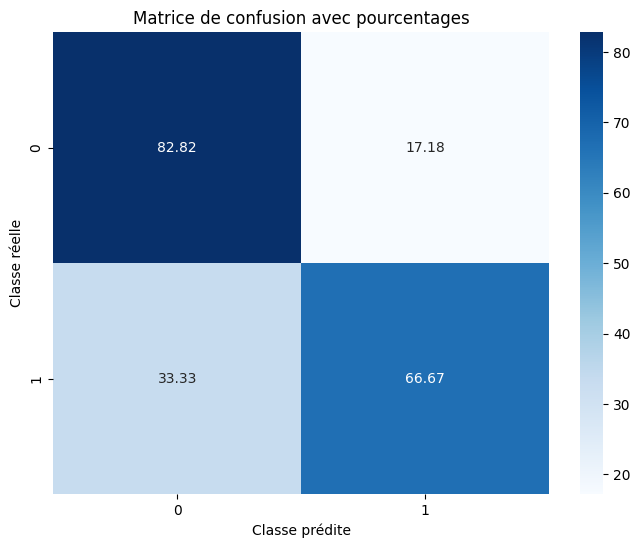

In [96]:


from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
  
# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

row_sums_lgbm = cm.sum(axis = 1)
cm_percent_lgbm = (cm.T / row_sums_lgbm).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lgbm, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()


In [101]:
import statsmodels.formula.api as smf

# Modèle GLM avec une famille binomiale (pour classification binaire)
model_glm = sm.GLM(y_train, X_train_scaled, family=sm.families.Binomial()).fit()

# Afficher le résumé
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   grav   No. Observations:               319499
Model:                            GLM   Df Residuals:                   319465
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7392e+05
Date:                Sat, 10 Aug 2024   Deviance:                   3.4785e+05
Time:                        01:20:46   Pearson chi2:                 3.36e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2362
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1645      0.011     15.334      0.0

: 

In [99]:
yhat = model_glm.predict(X_test_scaled) 
prediction = list(map(round, yhat)) 
  
# comparing original and predicted values of y 
print('Actual values', list(y_test.values)) 
print('Predictions :', prediction) 

ValueError: shapes (319499,34) and (136929,34) not aligned: 34 (dim 1) != 136929 (dim 0)

### Baseline models

In [13]:
models_list = [ DummyClassifier ,  LogisticRegression ,  RandomForestClassifier ,  BaggingClassifier ,  AdaBoostClassifier ,
                DecisionTreeClassifier ,  ExtraTreesClassifier ,
                KNeighborsClassifier ,  XGBClassifier ,  LGBMClassifier,  GradientBoostingClassifier  ]

In [14]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None,
                     predictions = True, classifiers=models_list)

models_train, predictions_train = clf.fit( X_train, X_train, y_train, y_train )

# predict à se renseigner !!
models_test, predictions_test = clf.fit( X_train, X_test, y_train, y_test )

 82%|████████▏ | 9/11 [05:48<01:36, 48.22s/it]

[LightGBM] [Info] Number of positive: 214976, number of negative: 151204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 366180, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587077 -> initscore=0.351896
[LightGBM] [Info] Start training from score 0.351896


100%|██████████| 11/11 [07:11<00:00, 39.19s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 82%|████████▏ | 9/11 [04:04<00:53, 26.68s/it]

[LightGBM] [Info] Number of positive: 214976, number of negative: 151204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 366180, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587077 -> initscore=0.351896
[LightGBM] [Info] Start training from score 0.351896


100%|██████████| 11/11 [05:25<00:00, 29.59s/it]


df = df.drop(['Accident_Id', 
                      "an_acc"], # doublon avec la variable "an"
                     axis=1)

# Supression des lignes contenant des données manquantes
df = df.dropna()

# Séparation du jeu de données pour entraîner le modèle
#train = df.loc[df.an.between(2019, 2021)] 
df_bis = df.loc[df.an.between(2020, 2022)]

train = df_bis.loc[df_bis.an.between(2020, 2021)]
test = df_bis.loc[df_bis.an == 2022]

print("DF: ", df_bis.shape,"TRAIN :", train.shape,"TEST :", test.shape)
print(" ")
print("La proportion du dataset train est de", round((train.shape[0]/ df_bis.shape[0]*100)),
      "% et du dataset test est de", round((test.shape[0]/ df_bis.shape[0]*100)), "%.")
print(" ")
X_train = train.drop(["grav"], axis=1)
y_train = train.grav

X_test = test.drop(["grav"], axis=1)
y_test = test.grav

print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Standardisation

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled_std = scaler.fit_transform(X_train)
X_test_scaled_std = scaler.transform(X_test)

from sklearn.preprocessing import RobustScaler

rbs = RobustScaler().fit(X_train)
X_train_scaled_rbs = rbs.transform(X_train)
X_test_scaled_rbs = rbs.transform(X_test)

### Ré-équilibrage de la variable cible

#### Undersampler avec std

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled_std, y_train_resampled = undersampler.fit_resample(X_train_scaled_std, y_train)

model_baseline_res = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

model_baseline_res.fit(X_train_resampled_std, y_train_resampled)
accuracy_res = model_baseline_res.score(X_test_scaled_std, y_test)
print("Accuracy :", round(accuracy_res,6))

y_pred = model_baseline_res.predict(X_test_scaled_std)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

print(classification_report_imbalanced(y_test, y_pred))

#### Undersampler avec robustscaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled_rbs, y_train_resampled = undersampler.fit_resample(X_train_scaled_rbs, y_train)

model_baseline_res = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

model_baseline_res.fit(X_train_resampled_rbs, y_train_resampled)
accuracy_res = model_baseline_res.score(X_test_scaled_rbs, y_test)
print("Accuracy :", round(accuracy_res,6))

y_pred = model_baseline_res.predict(X_test_scaled_rbs)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

print(classification_report_imbalanced(y_test, y_pred))

#### Oversampler avec std

from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

oversampler = RandomOverSampler(random_state=42)
X_train_resampov_std, y_train_resampov = oversampler.fit_resample(X_train_scaled_std, y_train)

model_baseline_res = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

model_baseline_res.fit(X_train_resampov_std, y_train_resampov)
accuracy_res = model_baseline_res.score(X_test_scaled_std, y_test)
print("Accuracy :", round(accuracy_res,6))

y_pred = model_baseline_res.predict(X_test_scaled_std)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

print(classification_report_imbalanced(y_test, y_pred))

#### Oversampler avec rbs

from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

oversampler = RandomOverSampler(random_state=42)
X_train_resampov_rbs, y_train_resampov = oversampler.fit_resample(X_train_scaled_rbs, y_train)

model_baseline_res = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

model_baseline_res.fit(X_train_resampov_rbs, y_train_resampov)
accuracy_res = model_baseline_res.score(X_test_scaled_rbs, y_test)
print("Accuracy :", round(accuracy_res,6))

y_pred = model_baseline_res.predict(X_test_scaled_rbs)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

print(classification_report_imbalanced(y_test, y_pred))

### Features select

###### Faire la standardisation avant de sélectionner les variables est moins coûteux en terme de temps de calculs.

# Recherche de la meilleure sélection de variables avec undersampling

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

best_accuracy = 0
best_k = 0

for k in range(1, X_train.shape[1] + 1):
    select_k_best = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best = select_k_best.fit_transform(X_train, y_train)
    X_test_k_best = select_k_best.transform(X_test)
    
    model_2 = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_2.fit(X_train_k_best, y_train)
    
    y_pred = model_2.predict(X_test_k_best)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print("Best number of features:", best_k)
print("Best accuracy:", best_accuracy)

# Recherche de la meilleure sélection de variables avec oversampling

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

best_accuracy = 0
best_k = 0

for k in range(1, X_train.shape[1] + 1):
    select_k_best = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best = select_k_best.fit_transform(X_train_resampov_, y_train_resampov)
    X_test_k_best = select_k_best.transform(X_test_scaled_rbs)
    
    model_2 = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_2.fit(X_train_k_best, y_train_resampov)
    
    y_pred = model_2.predict(X_test_k_best)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print("Best number of features:", best_k)
print("Best accuracy:", best_accuracy)

# sélection des k des meilleures features définies précédemment
test_stat =  SelectKBest(f_classif, k=33)
test_stat.fit(X_train_scaled, y_train)

for col, score in zip(X_train.columns, test_stat.scores_):
    print(col, ":", score)

X_train_selected = test_stat.transform(X_train_scaled)
X_test_selected = test_stat.transform(X_test_scaled)

### Baseline model

#### Régression logistique : recherche de la meilleure "normalisation" des données

In [49]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scaler_name, scaler in scalers.items():
    pipeline = make_pipeline(scaler, model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

    print(f"{scaler_name}: Accuracy moyenne = {scores.mean()}, Écart-type = {scores.std()}")
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print(f"{scaler_name} Classification Report:")
    print(report)

StandardScaler: Accuracy moyenne = 0.5920519420436421, Écart-type = 0.0012786740888283547
StandardScaler Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.77      0.68     48151
           2       0.42      0.00      0.01      2834
           3       0.46      0.19      0.27     17228
           4       0.58      0.59      0.59     47699

    accuracy                           0.59    115912
   macro avg       0.52      0.39      0.39    115912
weighted avg       0.57      0.59      0.56    115912

MinMaxScaler: Accuracy moyenne = 0.5920979551268069, Écart-type = 0.0011513296019927224
MinMaxScaler Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.77      0.68     48151
           2       0.33      0.00      0.00      2834
           3       0.46      0.19      0.27     17228
           4       0.58      0.59      0.59     47699

    accuracy                           0.

In [55]:
from sklearn.metrics import confusion_matrix

y_pred_log = model_baseline.predict(X_test_selected)

conf_matrix_log = confusion_matrix(y_test, y_pred_log)
print("Matrice de confusion :\n", conf_matrix_log)

row_sums_log = conf_matrix_log.sum(axis=1)
conf_matrix_percent_log = (conf_matrix_log.T / row_sums_log).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_log, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

NameError: name 'model_baseline' is not defined

#### Random forest : recherche de la meilleure "normalisation" des données

In [ ]:
model_rf = RandomForestClassifier(random_state=0, class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scaler_name, scaler in scalers.items():
    pipeline = make_pipeline(scaler, model_rf)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

    print(f"{scaler_name}: Accuracy moyenne = {scores.mean()}, Écart-type = {scores.std()}")

StandardScaler: Accuracy moyenne = 0.6836480886355647, Écart-type = 0.002237072983282108
MinMaxScaler: Accuracy moyenne = 0.6841743512852378, Écart-type = 0.0019054375241854794
RobustScaler: Accuracy moyenne = 0.6847408803498939, Écart-type = 0.0017425095708648525


#### KNN : recherche de la meilleure "normalisation" des données

In [ ]:
model_knn = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scaler_name, scaler in scalers.items():
    pipeline = make_pipeline(scaler, model_knn)
    
    undersampler = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
    
    print(f"{scaler_name}: Accuracy moyenne = {scores.mean()}, Écart-type = {scores.std()}")


StandardScaler: Accuracy moyenne = 0.45268491790183385, Écart-type = 0.002397667752622828
MinMaxScaler: Accuracy moyenne = 0.4256641721000968, Écart-type = 0.006467772030212853
RobustScaler: Accuracy moyenne = 0.4761988469142128, Écart-type = 0.0044322465651383085


#### XGBoost : recherche de la meilleure "normalisation" des données

In [ ]:
model_xgb = GradientBoostingClassifier(random_state=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for scaler_name, scaler in scalers.items():
    pipeline = make_pipeline(scaler, model_xgb)
    
    undersampler = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
    
    print(f"{scaler_name}: Accuracy moyenne = {scores.mean()}, Écart-type = {scores.std()}")

StandardScaler: Accuracy moyenne = 0.5778431280923595, Écart-type = 0.004693858083687763
MinMaxScaler: Accuracy moyenne = 0.5788491849679156, Écart-type = 0.004196471115224787
RobustScaler: Accuracy moyenne = 0.5779293638997789, Écart-type = 0.004602568547734059


In [15]:
print("Performances des modèles sur l'ensemble d'entraînement\n")
models_train

Performances des modèles sur l'ensemble d'entraînement



,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,1.00,1.00,1.00,1.00,5.94
ExtraTreesClassifier,1.00,1.00,1.00,1.00,62.75
RandomForestClassifier,1.00,1.00,1.00,1.00,79.02
BaggingClassifier,0.99,0.99,0.99,0.99,36.11
KNeighborsClassifier,0.82,0.81,0.81,0.82,144.76
LGBMClassifier,0.81,0.80,0.80,0.81,2.80
GradientBoostingClassifier,0.79,0.79,0.79,0.79,79.38
AdaBoostClassifier,0.78,0.78,0.78,0.78,17.91
LogisticRegression,0.72,0.70,0.70,0.71,1.40


In [16]:
print("Performances des modèles sur l'ensemble de test\n")
models_test

Performances des modèles sur l'ensemble de test



,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.81,0.81,0.81,0.81,75.59
ExtraTreesClassifier,0.81,0.80,0.80,0.81,56.42
LGBMClassifier,0.81,0.80,0.80,0.81,2.06
BaggingClassifier,0.79,0.79,0.79,0.79,36.39
GradientBoostingClassifier,0.79,0.79,0.79,0.79,78.93
AdaBoostClassifier,0.78,0.77,0.77,0.78,16.84
DecisionTreeClassifier,0.74,0.73,0.73,0.74,5.82
KNeighborsClassifier,0.72,0.72,0.72,0.73,51.85
LogisticRegression,0.71,0.70,0.70,0.71,0.97


## Sauvegarde du df

In [137]:
df.to_csv('dataset/df_go_modelisation.csv', index=False)